In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, gamma, halfnorm, laplace, norm, truncnorm
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import data_generator as dg

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# scale up demand
# - increase betas
# - increase noise

# re-paste code
# re-take and paste images

# 0) MMM data generator

In [2]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [1.0, 1.5, 0.5]
spend_scalars = [1.6, 1.4, 1.2]

df = dg.data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)

# Scale betas using maximum sales value - this is so it is comparable to the fitted beta from pymc (pymc does feature and target scaling using MaxAbsScaler from sklearn)
betas_scaled = [
    ((df["tv_sales"] / df["sales"].max()) / df["tv_saturated"]).mean(),
    ((df["social_sales"] / df["sales"].max()) / df["social_saturated"]).mean(),
    ((df["search_sales"] / df["sales"].max()) / df["search_saturated"]).mean()
]

# Calculate contributions
contributions = np.asarray([
    round((df["tv_sales"].sum() / df["sales"].sum()), 2),
    round((df["social_sales"].sum() / df["sales"].sum()), 2),
    round((df["search_sales"].sum() / df["sales"].sum()), 2),
    round((df["demand"].sum() / df["sales"].sum()), 2)
])

df[["date", "demand", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]]

,date,demand,tv_spend_raw,social_spend_raw,search_spend_raw,sales
0,2021-01-03,51.288831,81.779301,72.531477,61.685138,52.368989
1,2021-01-10,46.296845,74.293618,64.593164,55.933160,47.505957
2,2021-01-17,24.856830,40.147928,35.182646,29.674005,25.713175
3,2021-01-24,41.382295,65.019833,58.261301,50.282837,42.485452
4,2021-01-31,48.815899,78.592698,68.367986,59.197143,50.099973
...,...,...,...,...,...,...
151,2023-11-26,88.627458,141.899669,123.818666,106.905965,90.706122
152,2023-12-03,99.045762,158.667221,138.156461,118.594010,101.214833
153,2023-12-10,91.715495,146.081350,128.703643,110.627735,93.848903
154,2023-12-17,85.640566,138.096870,119.887229,102.185141,87.708123


In [3]:
betas_scaled

[0.008558974028773111, 0.012838461043159662, 0.0042794870143865555]

In [4]:
contributions

array([0.01, 0.01, 0.01, 0.98])

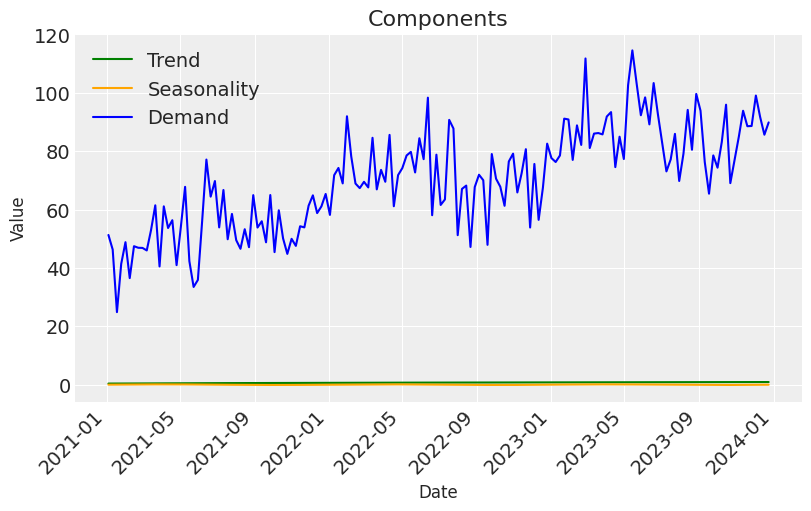

In [5]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['trend'], label="Trend", color="green")
sns.lineplot(x=df['date'], y=df['seasonality'], label="Seasonality", color="orange")
sns.lineplot(x=df['date'], y=df['demand'], label="Demand", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

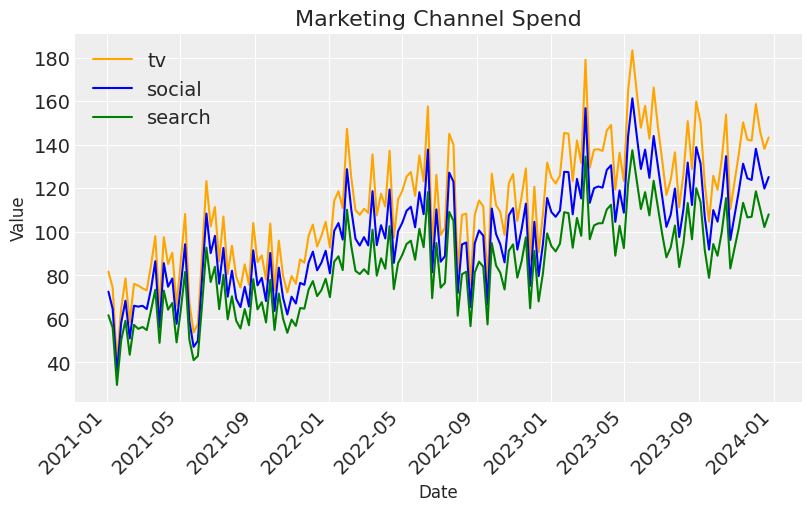

In [6]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['tv_spend_raw'], label=channels[0], color="orange")
sns.lineplot(x=df['date'], y=df['social_spend_raw'], label=channels[1], color="blue")
sns.lineplot(x=df['date'], y=df['search_spend_raw'], label=channels[2], color="green")
plt.title('Marketing Channel Spend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

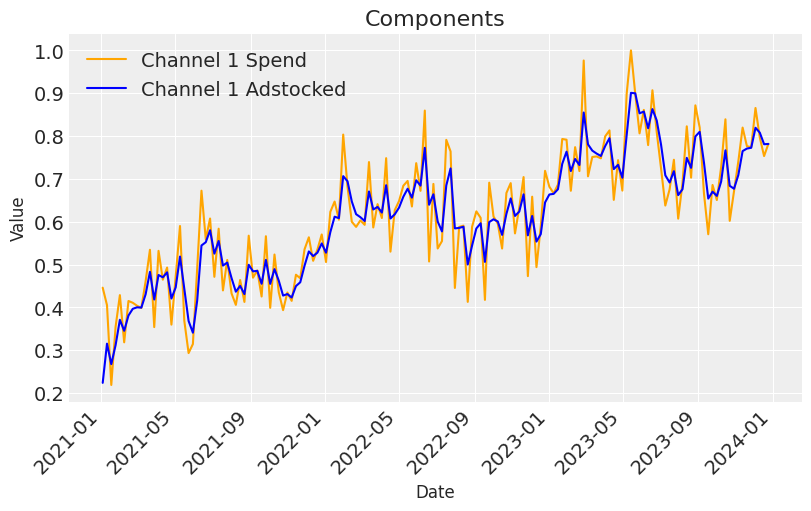

In [7]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['tv_spend'], label="Channel 1 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['tv_adstock'], label="Channel 1 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

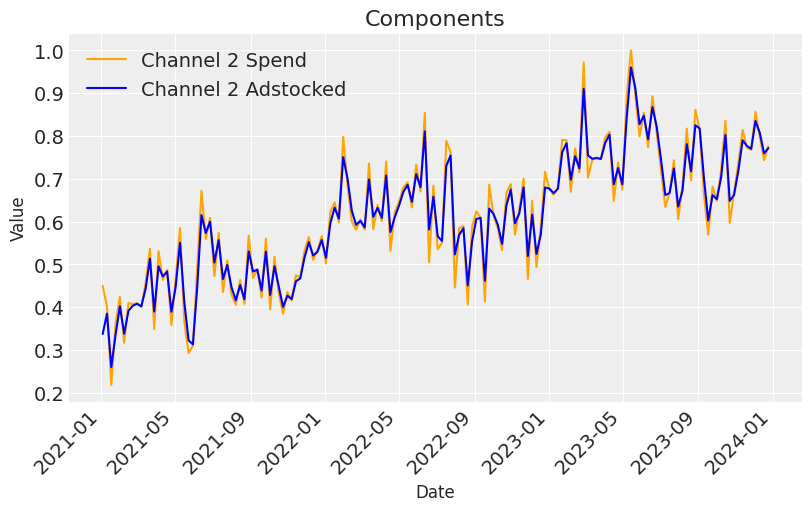

In [8]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['social_spend'], label="Channel 2 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['social_adstock'], label="Channel 2 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

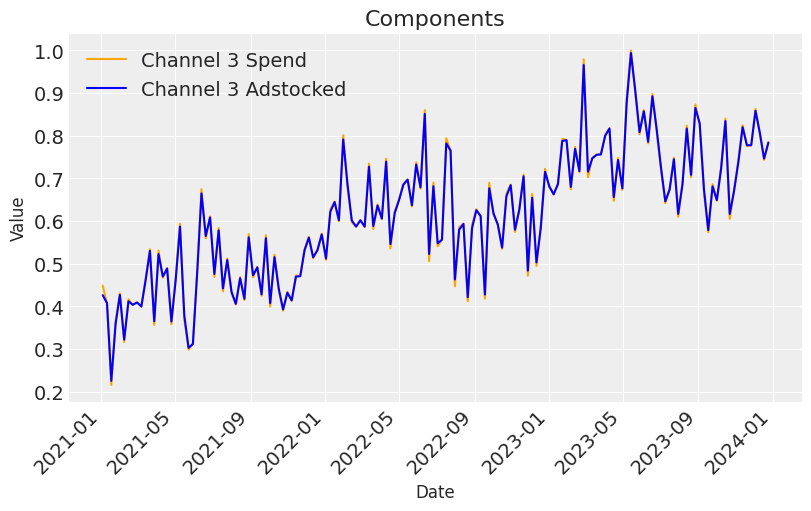

In [9]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['search_spend'], label="Channel 3 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['search_adstock'], label="Channel 3 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

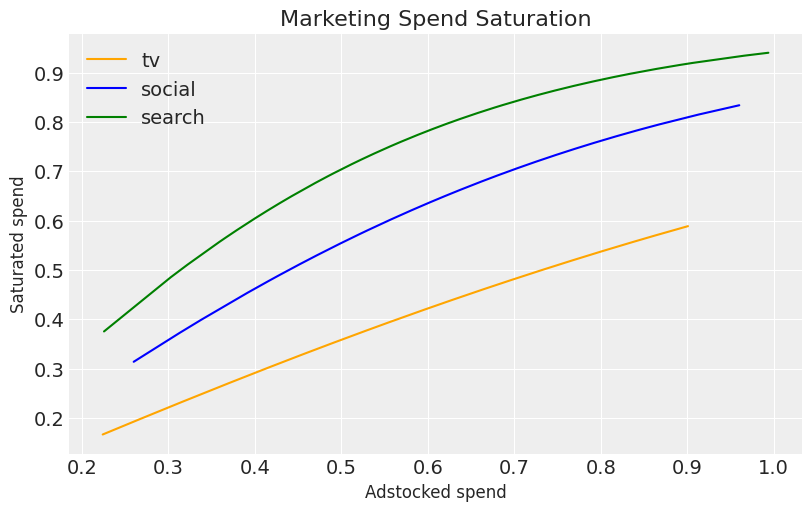

In [10]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['tv_adstock'], y=df['tv_saturated'], label=channels[0], color="orange")
sns.lineplot(x=df['social_adstock'], y=df['social_saturated'], label=channels[1], color="blue")
sns.lineplot(x=df['search_adstock'], y=df['search_saturated'], label=channels[2], color="green")

plt.title('Marketing Spend Saturation', fontsize=16)
plt.xlabel('Adstocked spend', fontsize=12)
plt.ylabel('Saturated spend', fontsize=12)
plt.legend()
plt.show()

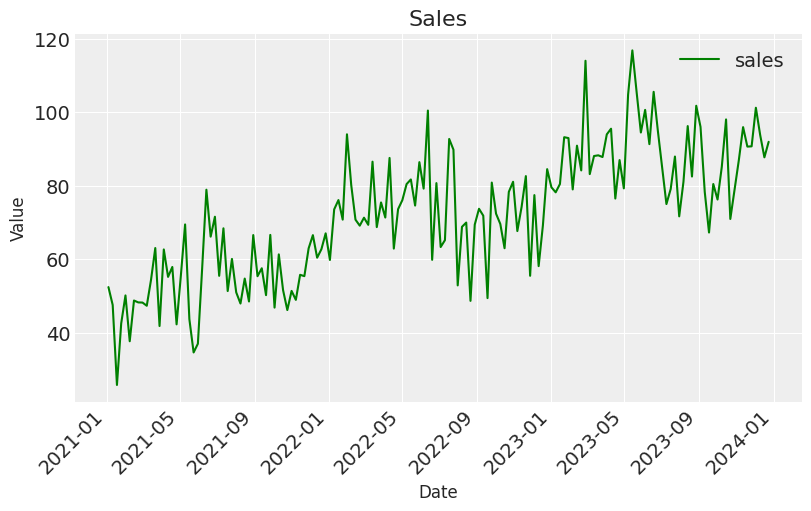

In [11]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['sales'], label="sales", color="green")

plt.title('Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# 1) Understanding the model and default priors

In [19]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

### Geometric adstock

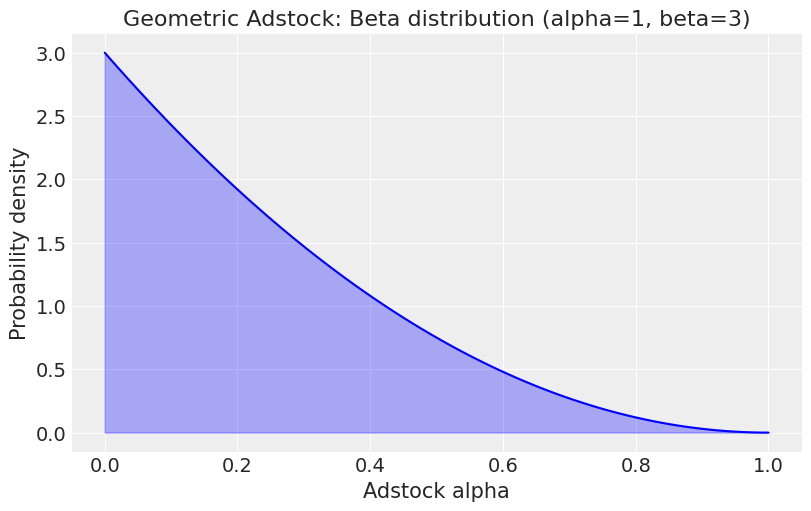

In [20]:
alpha = 1
beta_param = 3

x1 = np.linspace(0, 1, 100)
y1 = beta.pdf(x1, alpha, beta_param)

plt.figure(figsize=(8, 5))
plt.plot(x1, y1, color='blue')
plt.fill_between(x1, y1, color='blue', alpha=0.3)
plt.title('Geometric Adstock: Beta distribution (alpha=1, beta=3)')
plt.xlabel('Adstock alpha')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

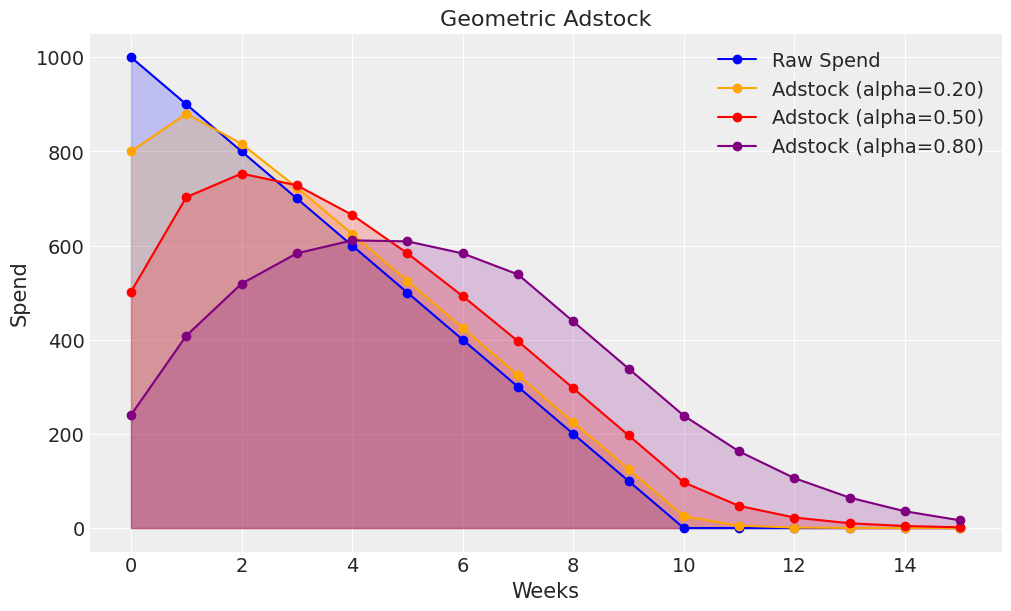

In [21]:
raw_spend = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0, 0, 0, 0, 0, 0])

adstock_spend_1 = geometric_adstock(x=raw_spend, alpha=0.20, l_max=8, normalize=True).eval().flatten()
adstock_spend_2 = geometric_adstock(x=raw_spend, alpha=0.50, l_max=8, normalize=True).eval().flatten()
adstock_spend_3 = geometric_adstock(x=raw_spend, alpha=0.80, l_max=8, normalize=True).eval().flatten()

plt.figure(figsize=(10, 6))

plt.plot(raw_spend, marker='o', label='Raw Spend', color='blue')
plt.fill_between(range(len(raw_spend)), 0, raw_spend, color='blue', alpha=0.2)

plt.plot(adstock_spend_1, marker='o', label='Adstock (alpha=0.20)', color='orange')
plt.fill_between(range(len(adstock_spend_1)), 0, adstock_spend_1, color='orange', alpha=0.2)

plt.plot(adstock_spend_2, marker='o', label='Adstock (alpha=0.50)', color='red')
plt.fill_between(range(len(adstock_spend_2)), 0, adstock_spend_2, color='red', alpha=0.2)

plt.plot(adstock_spend_3, marker='o', label='Adstock (alpha=0.80)', color='purple')
plt.fill_between(range(len(adstock_spend_3)), 0, adstock_spend_3, color='purple', alpha=0.2)

plt.xlabel('Weeks')
plt.ylabel('Spend')
plt.title('Geometric Adstock')
plt.legend()
plt.grid(True)
plt.show()


### Logistic saturation

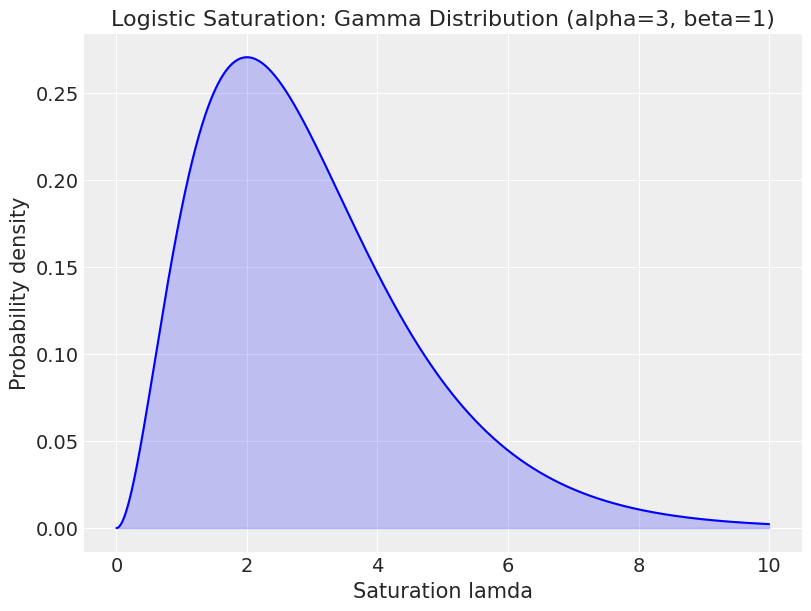

In [22]:
alpha = 3
beta = 1

x2 = np.linspace(0, 10, 1000)
y2 = gamma.pdf(x2, alpha, scale=1/beta)

plt.figure(figsize=(8, 6))
plt.plot(x2, y2, 'b-')
plt.fill_between(x2, y2, alpha=0.2, color='blue')
plt.title('Logistic Saturation: Gamma Distribution (alpha=3, beta=1)')
plt.xlabel('Saturation lamda')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

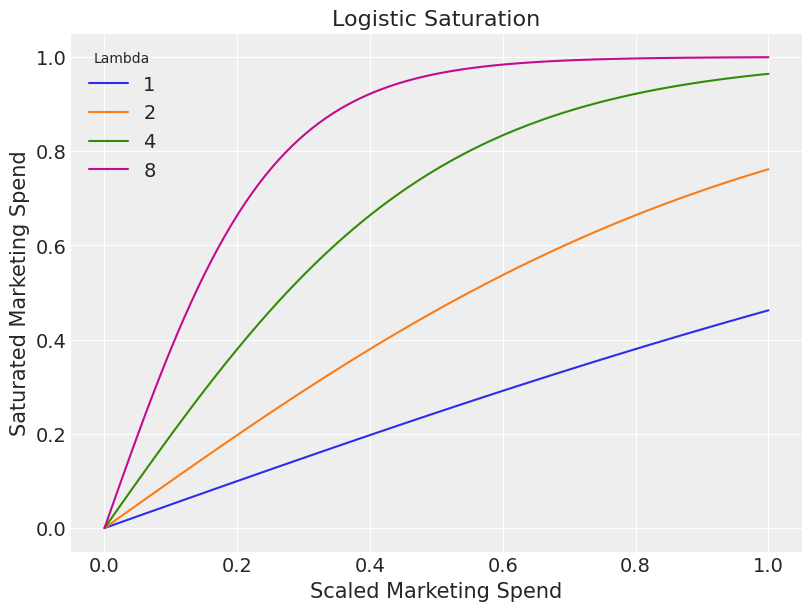

In [23]:
scaled_spend = np.linspace(start=0.0, stop=1.0, num=100)

saturated_spend_1 = logistic_saturation(x=scaled_spend, lam=1).eval()
saturated_spend_2 = logistic_saturation(x=scaled_spend, lam=2).eval()
saturated_spend_4 = logistic_saturation(x=scaled_spend, lam=4).eval()
saturated_spend_8 = logistic_saturation(x=scaled_spend, lam=8).eval()

plt.figure(figsize=(8, 6))
sns.lineplot(x=scaled_spend, y=saturated_spend_1, label="1")
sns.lineplot(x=scaled_spend, y=saturated_spend_2, label="2")
sns.lineplot(x=scaled_spend, y=saturated_spend_4, label="4")
sns.lineplot(x=scaled_spend, y=saturated_spend_8, label="8")

plt.title('Logistic Saturation')
plt.xlabel('Scaled Marketing Spend')
plt.ylabel('Saturated Marketing Spend')
plt.legend(title='Lambda')
plt.grid(True)
plt.show()

### Saturation beta

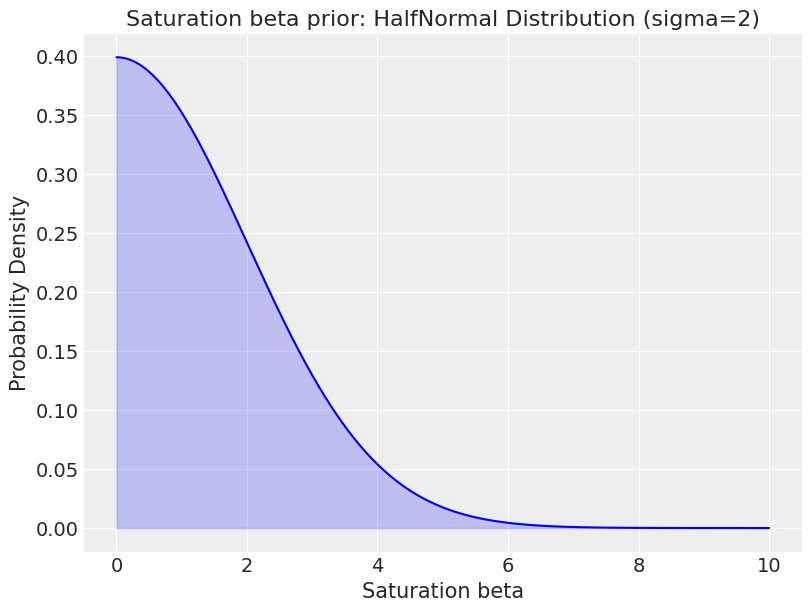

In [24]:
sigma = 2

x = np.linspace(0, 10, 1000)
y = halfnorm.pdf(x, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'b-')
plt.fill_between(x, y, alpha=0.2, color='blue')
plt.title('Saturation beta prior: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

# 2) Fit model

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              156 non-null    datetime64[ns]
 1   trend             156 non-null    float64       
 2   seasonality       156 non-null    float64       
 3   demand            156 non-null    float64       
 4   sales             156 non-null    float64       
 5   tv_spend_raw      156 non-null    float64       
 6   tv_spend          156 non-null    float64       
 7   tv_adstock        156 non-null    float64       
 8   tv_saturated      156 non-null    float64       
 9   tv_sales          156 non-null    float64       
 10  social_spend_raw  156 non-null    float64       
 11  social_spend      156 non-null    float64       
 12  social_adstock    156 non-null    float64       
 13  social_saturated  156 non-null    float64       
 14  social_sales      156 non-

In [26]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_spend_raw",
                "social_spend_raw",
                "search_spend_raw"]

# create arrays
X = df[[date_col] + channel_cols]
y = df[y_col]

# set test (out-of-sample) length
test_len = 8

# create train and test indexs
train_idx = slice(0, len(df) - test_len)
out_of_time_idx = slice(len(df) - test_len, len(df))

In [62]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    yearly_seasonality=4,
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [63]:
mmm_default.fit(X[train_idx], y[train_idx])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

# 3) Validate model

In [64]:
mmm_default.idata["sample_stats"]["diverging"].sum().item()

0

In [65]:
az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_fourier",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.034,0.021,-0.006,0.071,0.001,0.000,1558.0,2490.0,1.0
y_sigma,0.030,0.002,0.027,0.034,0.000,0.000,3282.0,2748.0,1.0
saturation_beta[tv_spend_raw],1.067,0.576,0.383,2.085,0.014,0.010,1873.0,2271.0,1.0
saturation_beta[social_spend_raw],0.807,0.228,0.542,1.191,0.006,0.005,1935.0,1514.0,1.0
saturation_beta[search_spend_raw],0.215,0.044,0.162,0.270,0.002,0.002,1680.0,1000.0,1.0
saturation_lam[tv_spend_raw],1.070,0.506,0.250,1.987,0.011,0.008,1836.0,2236.0,1.0
saturation_lam[social_spend_raw],1.925,0.502,0.960,2.849,0.012,0.008,1908.0,1496.0,1.0
saturation_lam[search_spend_raw],3.408,0.846,1.837,5.010,0.022,0.016,1565.0,920.0,1.0
adstock_alpha[tv_spend_raw],0.585,0.056,0.478,0.691,0.001,0.001,2908.0,2516.0,1.0
adstock_alpha[social_spend_raw],0.314,0.039,0.236,0.382,0.001,0.001,2777.0,2460.0,1.0


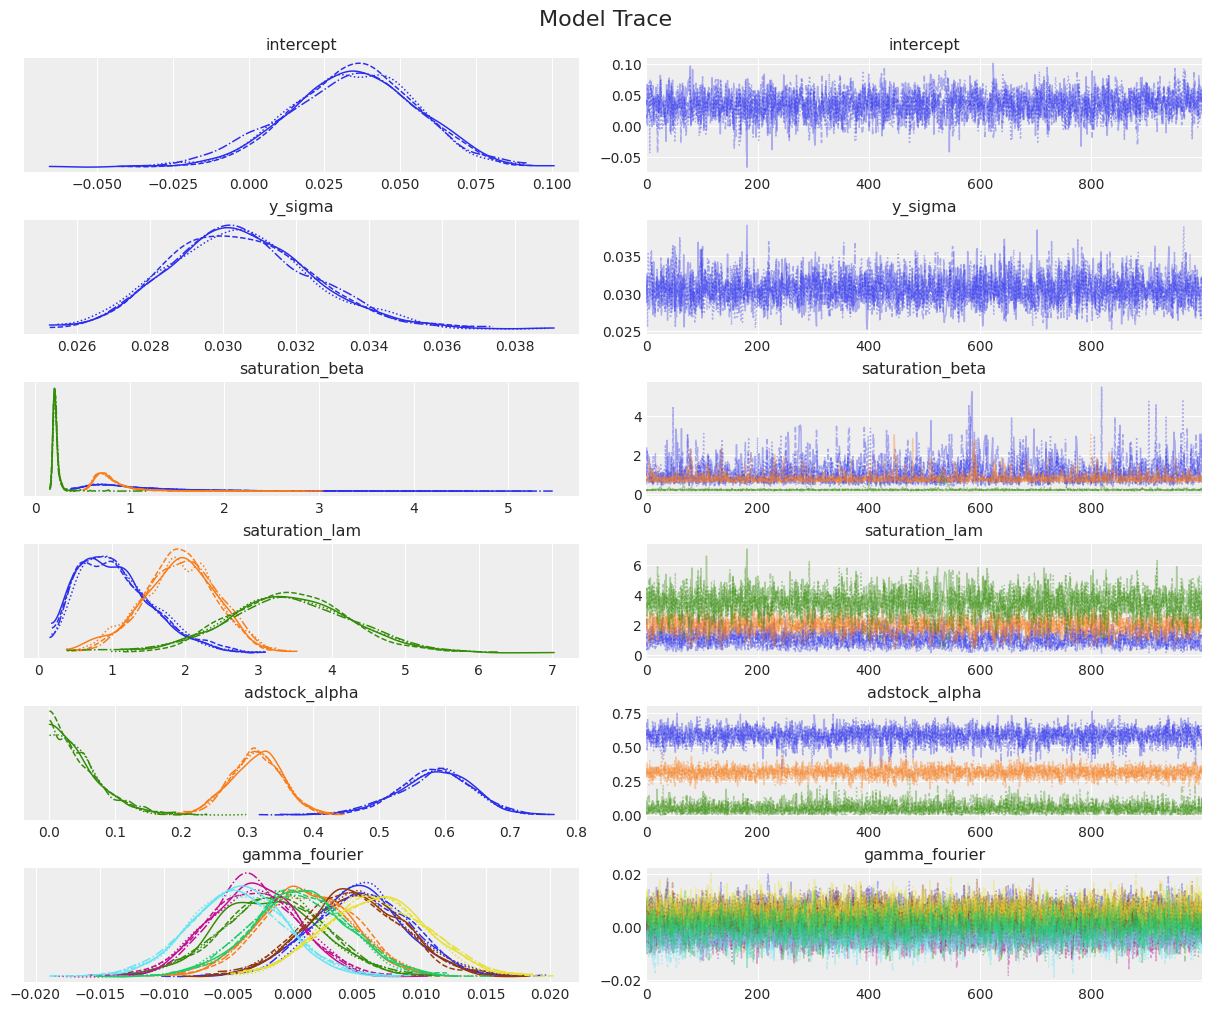

In [66]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [67]:
mmm_default.sample_posterior_predictive(X[train_idx], extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 5MB
Dimensions:  (sample: 4000, date: 148)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2021-01-03 2021-01-10 ... 2023-10-29
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int32 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 5MB 1.314 1.456 1.452 ... 2.06 1.761 1.929
Attributes:
    created_at:                 2024-09-20T11:46:43.102742+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

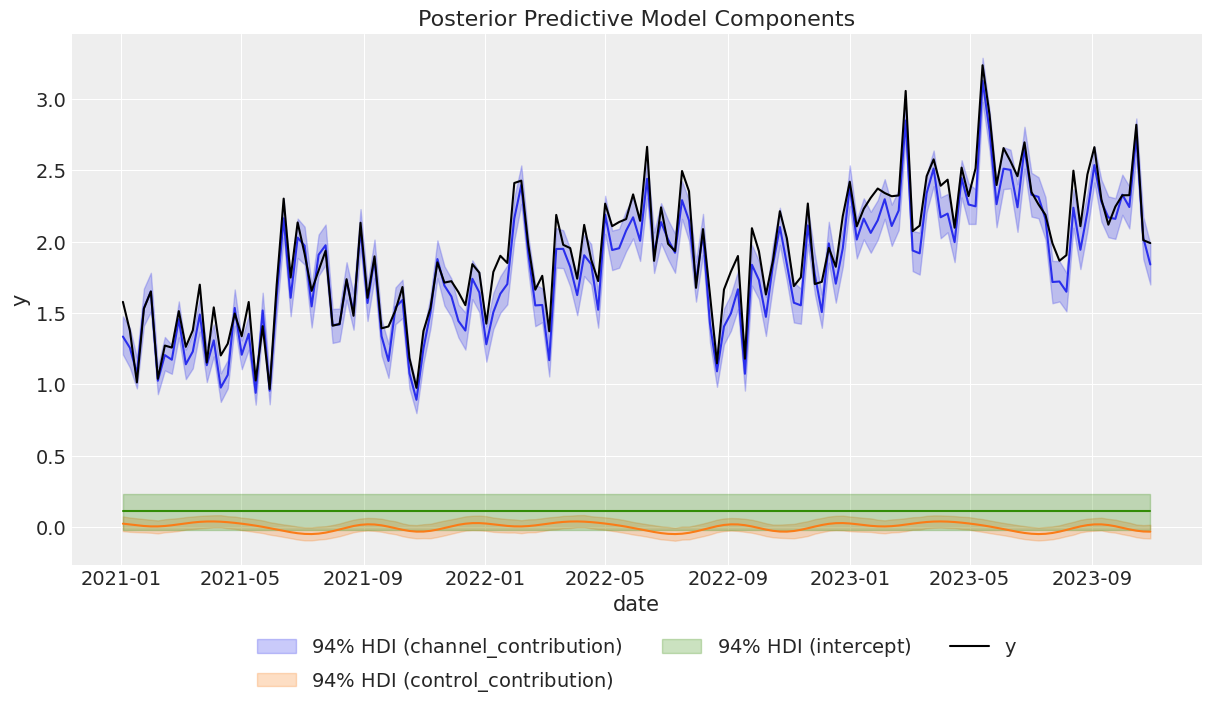

In [68]:
mmm_default.plot_components_contributions(original_scale=True);

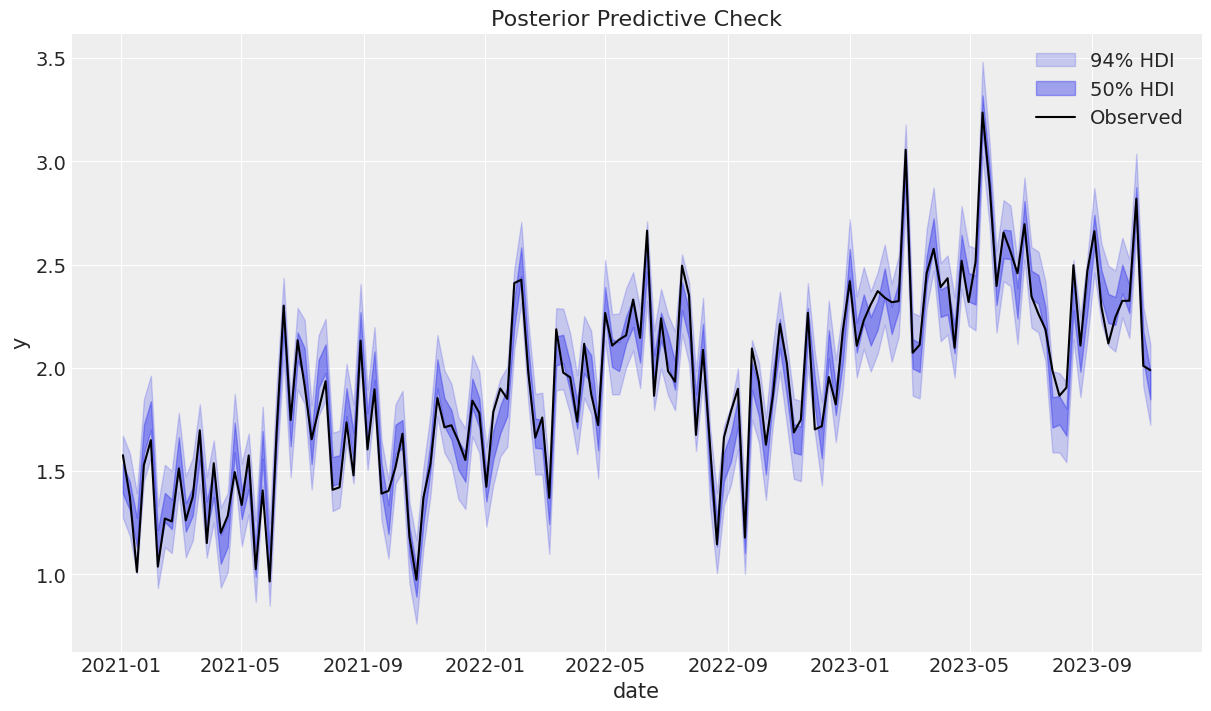

In [69]:
mmm_default.plot_posterior_predictive(original_scale=True);

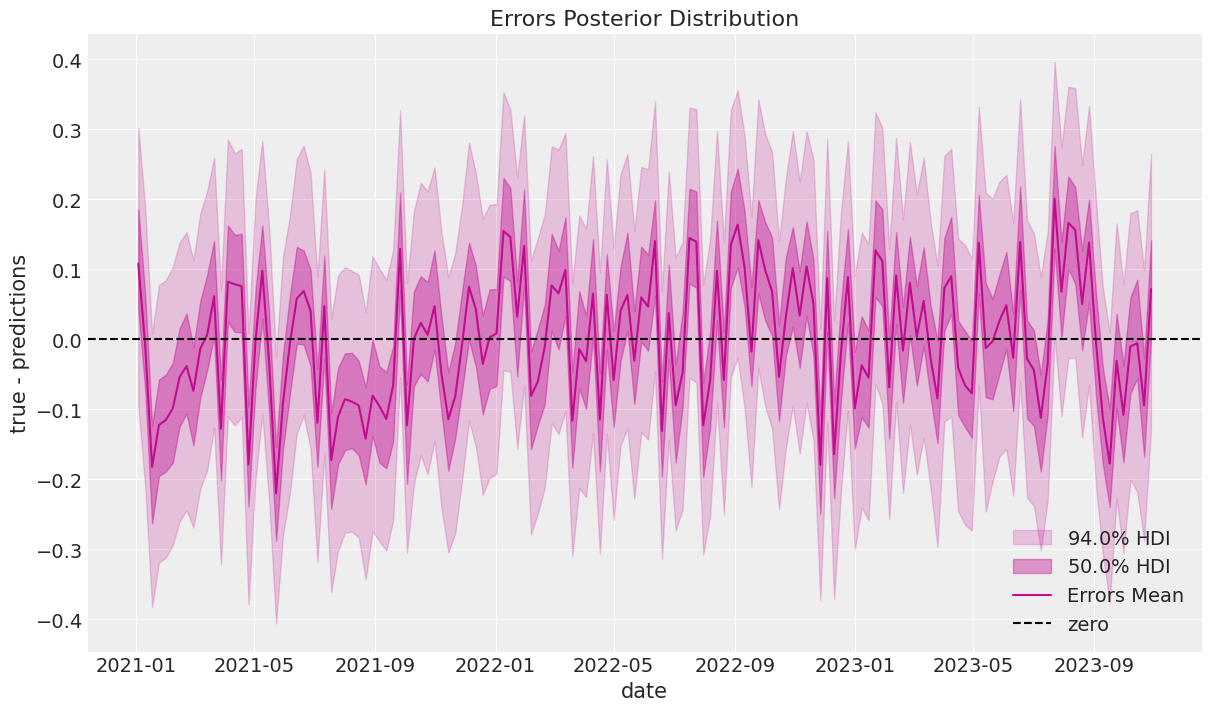

In [70]:
mmm_default.plot_errors(original_scale=True);

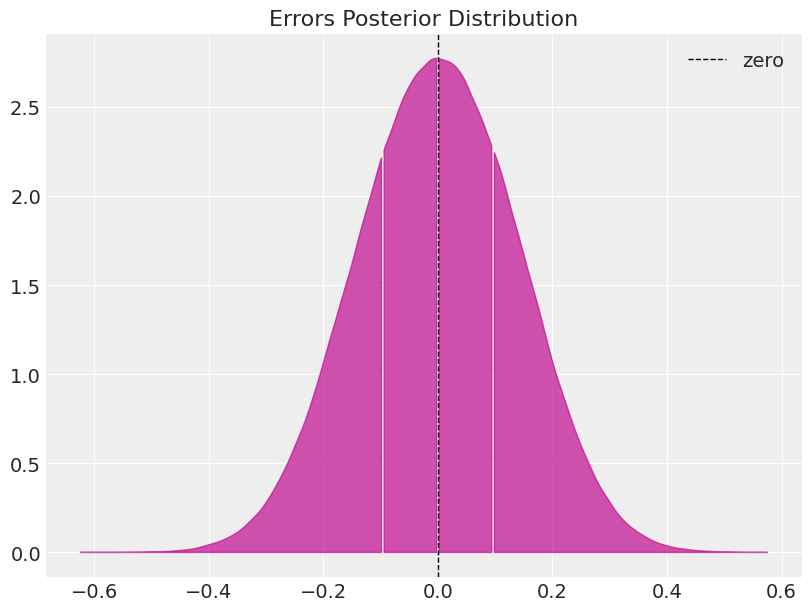

In [71]:
errors = mmm_default.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

In [72]:
y_out_of_sample = mmm_default.sample_posterior_predictive(
    X_pred=X[out_of_time_idx], extend_idata=False, include_last_observations=True
)

y_out_of_sample

Sampling: [y]


Output()

<xarray.Dataset> Size: 320kB
Dimensions:  (sample: 4000, date: 8)
Coordinates:
  * date     (date) datetime64[ns] 64B 2023-11-05 2023-11-12 ... 2023-12-24
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int32 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 256kB 2.118 2.082 2.061 ... 2.128 2.226
Attributes:
    created_at:                 2024-09-20T11:46:52.981826+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

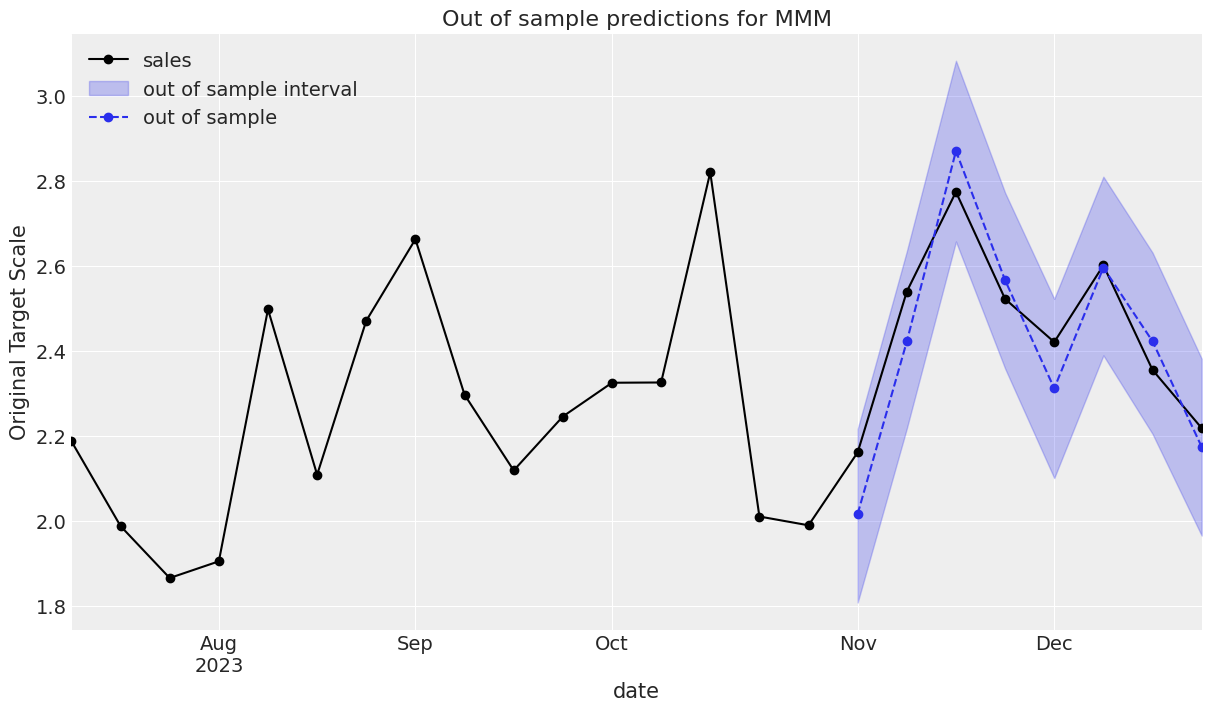

In [73]:
def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X[date_col])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample[date_col].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax, n_points=len(X[out_of_time_idx])*3)
plot_out_of_sample(
    X[out_of_time_idx], y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");

# 4) Parameter validation - Adstock

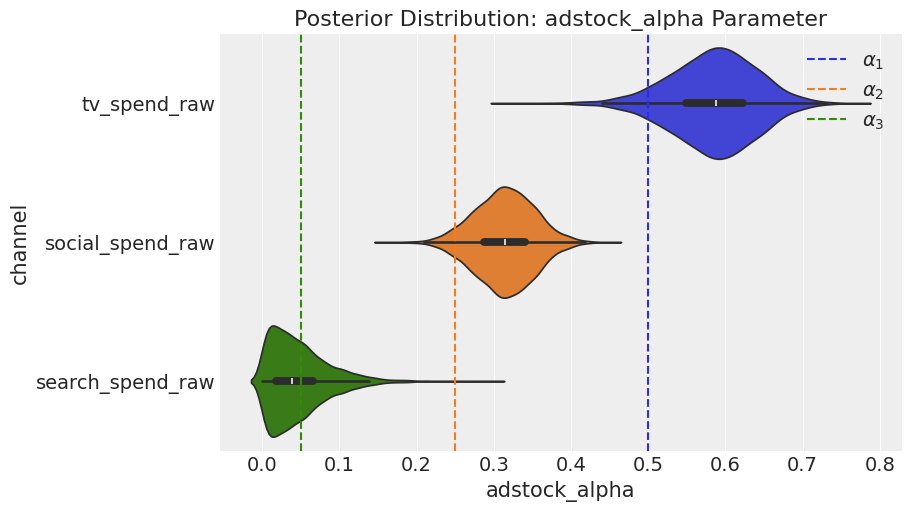

In [74]:
fig = mmm_default.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=adstock_alphas[0], color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=adstock_alphas[1], color="C1", linestyle="--", label=r"$\alpha_2$")
ax.axvline(x=adstock_alphas[2], color="C2", linestyle="--", label=r"$\alpha_3$")
ax.legend(loc="upper right");

# 5) Parameter validation - Saturation

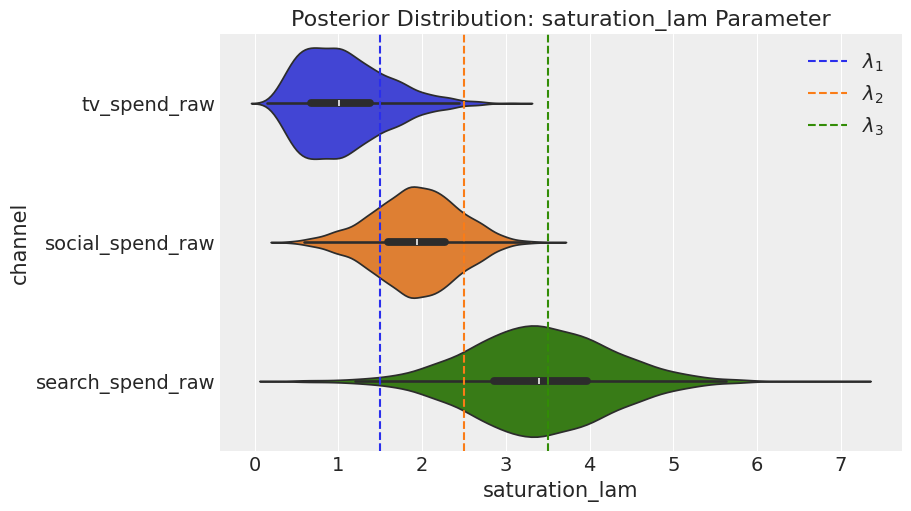

In [75]:
fig = mmm_default.plot_channel_parameter(param_name="saturation_lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=saturation_lamdas[0], color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=saturation_lamdas[1], color="C1", linestyle="--", label=r"$\lambda_2$")
ax.axvline(x=saturation_lamdas[2], color="C2", linestyle="--", label=r"$\lambda_3$")
ax.legend(loc="upper right");

# 6) Parameter validation - Channel betas

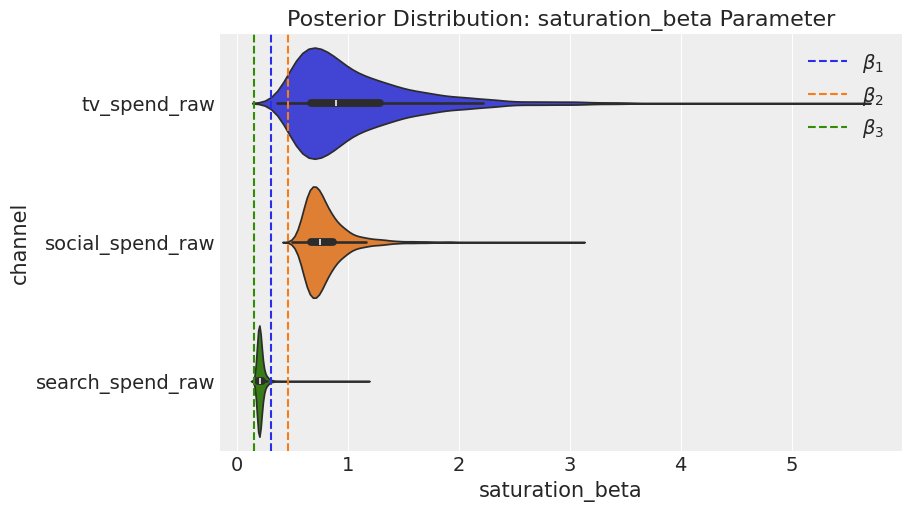

In [76]:
fig = mmm_default.plot_channel_parameter(param_name="saturation_beta", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=betas_scaled[0], color="C0", linestyle="--", label=r"$\beta_1$")
ax.axvline(x=betas_scaled[1], color="C1", linestyle="--", label=r"$\beta_2$")
ax.axvline(x=betas_scaled[2], color="C2", linestyle="--", label=r"$\beta_3$")
ax.legend(loc="upper right");

In [77]:
channels = np.array(["tv", "social", "search", "demand"])

true_contributions = pd.DataFrame({'Channels': channels, 'Contributions': contributions})
true_contributions= true_contributions.sort_values(by='Contributions', ascending=False).reset_index(drop=True)
true_contributions = true_contributions.style.bar(subset=['Contributions'], color='lightblue')

true_contributions

,Channels,Contributions
0,demand,0.360000
1,social,0.340000
2,tv,0.160000
3,search,0.140000


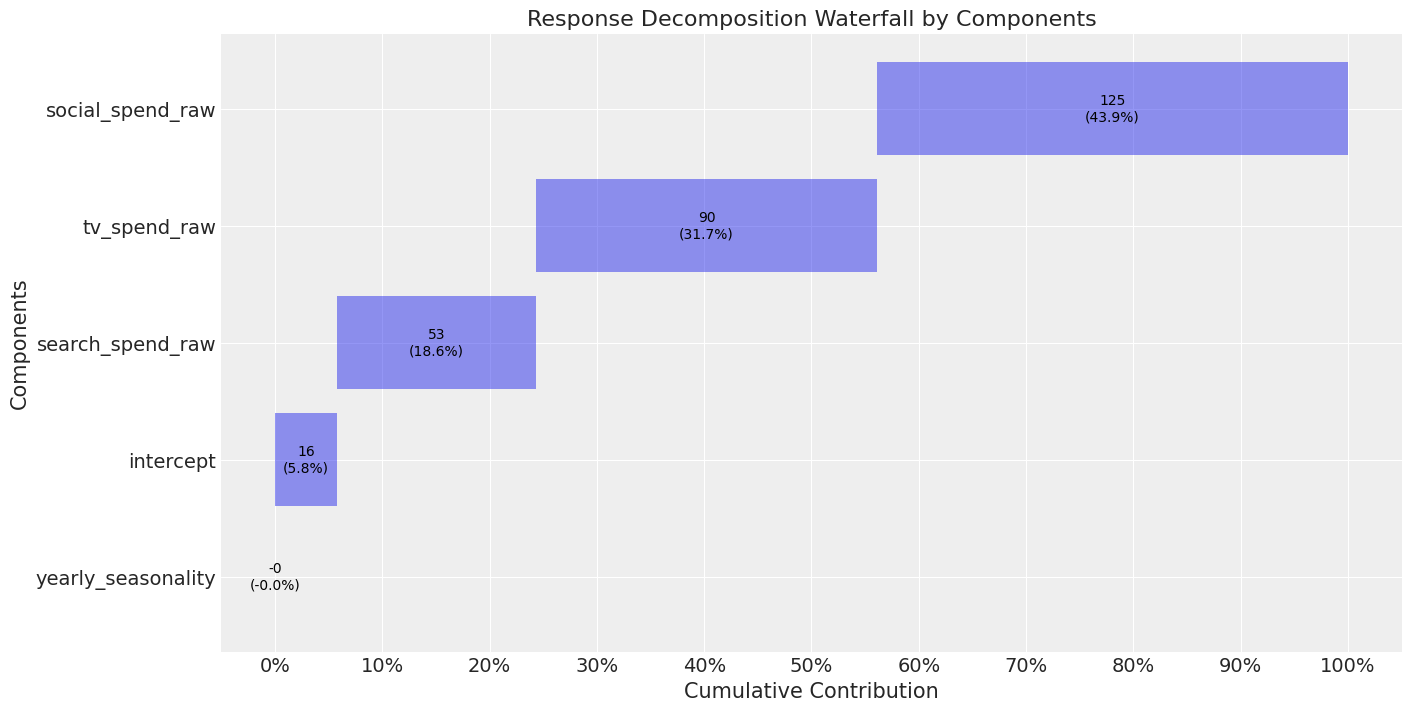

In [78]:
mmm_default.plot_waterfall_components_decomposition();